In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
import torchvision
import os
from torchvision.transforms import v2
import glob
import torch.nn.functional as F
from torchvision.models import ResNet50_Weights
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

## Plotter

In [2]:
class Plotter:

    def plot_training_val_b1(self, training_loss, val_loss, val_accuracy):
        epochs = range(1, len(training_loss) + 1)

        fig, ax1 = plt.subplots()
        ax1.plot(epochs, training_loss, 'b-', label='Training Loss')
        ax1.plot(epochs, val_loss, 'r-', label='Validation Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.set_title('Training and Validation Loss')

        plt.figure()
        plt.plot(epochs, val_accuracy, 'g-', label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Validation Accuracy')

        plt.show()

plotter = Plotter()

## Data Processing

In [3]:
class AnnotationProcessor:
    def __init__(self, base_path, output_path='/kaggle/working/', filename='dataset.csv'):
        self.base_path = base_path
        self.output_path = output_path
        self.filename = filename
        self.data = None
        self.run()

    def get_group_annotation(self, file, folder_name):
        """Extract the first two elements from each row of the annotation file."""
        with open(file, 'r') as f:
            data = [line.split()[:2] for line in f]

        df = pd.DataFrame(data, columns=['FrameID', 'Label'])
        df['video_names'] = folder_name
## ['l-spike', 'l_set', 'r_set', 'r-pass', 'r_spike', 'l-pass',
       #'r_winpoint', 'l_winpoint']
        label_mapping = {'l-spike': 0, 'l_set': 1, 'r_set': 2, 'r-pass': 3, 'r_spike': 4, 'l-pass': 5, 'r_winpoint': 6, 'l_winpoint': 7}
        df['Mapped_Label'] = df['Label'].map(label_mapping).astype('int64')
        # Ensure the output directory exists
        os.makedirs(self.output_path, exist_ok=True)
        # Save the file directly in the root of the output path
        df.to_csv(os.path.join(self.output_path, f'{folder_name}.csv'), index=False)

    def process_annotations(self):
        """Process annotations from all folders in the base path."""
        for folder_name in os.listdir(self.base_path):
            folder_path = os.path.join(self.base_path, folder_name)
            if os.path.isdir(folder_path):
                annotated_file_path = os.path.join(folder_path, 'annotations.txt')
                self.get_group_annotation(annotated_file_path, folder_name)

    def combine_csv_files(self):
        """Combine all CSV files into a single DataFrame."""
        csv_files = glob.glob(os.path.join(self.output_path, '*.csv'))
        data = [pd.read_csv(csv_file) for csv_file in csv_files]
        for d in data:
            d.dropna(inplace=True)
            # print(d.isna().sum())
        return pd.concat(data, ignore_index=True)

    def generate_img_paths(self, df):
        """Generate image paths based on the DataFrame."""
        df['img_path'] = df.apply(
            lambda x: os.path.join(
                self.base_path,
                str(x['video_names']),  # Ensure `video_names` is a string
                str(x['FrameID'])[:-4],  # Ensure `FrameID` is a string and remove the last 4 characters
                str(x['FrameID'])  # Ensure `FrameID` is a string
            ), axis=1
        )
        return df

    def save_combined_data(self, df):
        """Save the combined data to a CSV file."""
        # Ensure the output directory exists before saving
        os.makedirs(self.output_path, exist_ok=True)
        # Save the combined data directly in the root of the output path
        df.to_csv(os.path.join(self.output_path, self.filename), index=False)

    def cleanup(self):
        """Delete all intermediate CSV files except the final output file."""
        for csv_file in glob.glob(os.path.join(self.output_path, '*.csv')):
            if not csv_file.endswith(self.filename):
                os.remove(csv_file)

    def run(self):
        """Run the whole annotation processing pipeline."""
        self.process_annotations()
        combined_data = self.combine_csv_files()
        data_with_paths = self.generate_img_paths(combined_data)
        self.save_combined_data(data_with_paths)
        self.cleanup()  # Clean up intermediate files
        self.data = pd.read_csv(os.path.join(self.output_path, self.filename))


Make sure you want to run this before running it

In [3]:
!rm -rf '/kaggle/working/'

rm: cannot remove '/kaggle/working/': Device or resource busy


In [4]:
base_path = '/kaggle/input/volleyball/volleyball_/videos/'
df = AnnotationProcessor(base_path, 'dataset.csv').data

## Model

In [5]:
class ResnetEvolution(nn.Module):
    def __init__(self, hidden_layers=[128, 64, 32]):
        super(ResnetEvolution, self).__init__()
        self.hidden_layers = hidden_layers
        self.model = self.__init_backbone(torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2))

    def __init_backbone(self, backbone):
        num_features = backbone.fc.in_features

        layers = []
        input_size = num_features  # Start with backbone output size
        for hidden_size in self.hidden_layers:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())  # Activation function
            input_size = hidden_size  # Update input for next layer

        layers.append(nn.Linear(input_size, 8))  # Final output layer

        backbone.fc = nn.Sequential(*layers)  # Output layer for binary classification

        return backbone

    def get_fc(self):
        return self.model.fc

    def forward(self, images):
        return self.model(images)

## Trainer

In [6]:
class b1_ModelTrainer:
    def __init__(self, model, optimizer, scheduled, criterion, epochs, dataloaders, device, save_folder, is_continue=False, checkpoint=None):
        self.model = model
        self.optimizer = optimizer
        self.scheduled = scheduled
        self.criterion = criterion
        self.epochs = epochs
        self.dataloaders = dataloaders
        self.DEVICE = device
        self.save_folder = save_folder
        self.is_continue = is_continue
        self.checkpoint = checkpoint

    #verbose 1 : checkpoint,
    #verbose 3:  labels, preds
    #verbose 4: logits
    def train_model(self, verbose=0):
        model, optimizer, criterion, epochs, dataloaders = self.model, self.optimizer, self.criterion, self.epochs, self.dataloaders

        epoch = 0

        train_losses = []
        val_losses = []
        val_accuracies = []

        if self.is_continue:

            if verbose>0:
                print(f"Continuing from checkpoint {self.checkpoint}")

            epoch, model, optimizer = self.__load_checkpoint(model, optimizer, self.checkpoint, verbose)

        for training_epoch in range(epoch, epochs):

            # print(f"\nTraining epoch {training_epoch}: training {'full model' if self.__check_transfer_learning(training_epoch/epochs) else 'only fc model'}")

            ## change model mode depending on the phase
            for phase in ['train', 'val']:
                dataloader = dataloaders[phase]
                epoch_loss = 0  # Track total loss for the epoch
                if phase == 'train':
                    model.train()
                    for inputs, labels in tqdm(dataloader, desc=phase):

                        inputs = inputs.to(self.DEVICE)
                        labels = labels.to(self.DEVICE)

                        if verbose > 3:
                            print(f"labels: {labels}")

                        # zero grads of he optim
                        optimizer.zero_grad()

                        # freeze the non-learnable weights
                        # self.__handle_transfer_learning(phase, training_epoch / epochs)

                        # forward pass
                        logit = model(inputs)

                        if verbose > 3:
                            print(f"logit: {logit}")

                        loss = criterion(logit, labels)
                        loss.backward()
                        # update weights
                        optimizer.step()
                        epoch_loss += loss.item()  # Accumulate loss

                    train_losses.append(epoch_loss / len(dataloader))
                    print(
                        f"Epoch {training_epoch + 1}/{epochs}, {phase} Loss: {epoch_loss / len(dataloader)}")  # Print loss
                else:
                    # skip evaluation if no suitable dataloader
                    if dataloaders[phase] is None:
                        continue
                    model.eval()
                    loss, acc = self.__eval_model(dataloader, verbose)
                    val_losses.append(loss)
                    val_accuracies.append(acc)
                    print(f"Epoch {training_epoch + 1}/{epochs}, ({phase}) Loss: {loss} | Accuracy: {acc}")  # Print loss

            if self.scheduled:
                optimizer.scheduler_step()
                self.__save_checkpoint(training_epoch, model.state_dict(), optimizer.optimizer_state_dict(), optimizer.scheduler_state_dict(), verbose)
            else:
                self.__save_checkpoint(training_epoch, model.state_dict(), optimizer.state_dict(), verbose)

        self.__save_model(verbose)
        return train_losses, val_losses, val_accuracies

    def __handle_transfer_learning(self, phase, ratio_epochs, tl_coeff=0, verbose=0):
        if phase == "train":
            if self.__check_transfer_learning(ratio_epochs, tl_coeff):
                # Unfreeze all layers for fine-tuning
                for param in self.model.parameters():
                    param.requires_grad = True
            else:
                # Freeze the CNN part
                for param in self.model.parameters():
                    param.requires_grad = False
                # Unfreeze the classification layer
                for param in self.model.get_fc().parameters():
                    param.requires_grad = True
        elif phase == "val":
            for param in self.model.parameters():
                param.requires_grad = False

    def __check_transfer_learning(self, ratio_epochs, tl_coeff=0):
        return ratio_epochs >= tl_coeff

    def __eval_model(self, dataloader, verbose=0):
        model = self.model
        criterion = self.criterion
        model.eval()
        val_loss = 0
        correct_preds = 0
        total_preds = 0

        with torch.no_grad():
            for inputs, labels in tqdm(dataloader, desc="Evaluating"):
                inputs = inputs.to(self.DEVICE)
                labels = labels.to(self.DEVICE)

                if verbose > 2:
                    print(f"labels: {labels}")

                # Forward pass
                logits = model(inputs)

                if verbose > 3:
                    print(f"logit: {logits}")

                probs = F.softmax(logits, dim=1)  # Apply softmax to get probabilities

                if verbose > 3:
                    print(f"probs: {probs}")

                loss = criterion(logits, labels)
                val_loss += loss.item()  # Accumulate loss

                # Compute accuracy
                predicted = torch.argmax(probs, dim=1)  # Get the class with the highest probability

                if verbose > 2:
                    print(f"predicted: {predicted}")
                    print(f"true/false: {(predicted == labels)}")

                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        # Calculate average loss and accuracy
        avg_loss = val_loss / len(dataloader)
        accuracy = correct_preds / total_preds
        return avg_loss, accuracy

    def __save_model(self, verbose=0):
        torch.save(self.model.state_dict(), self.save_folder + "/b1_model.pth")
        if verbose > 0:
            print(f"Saved model to {self.save_folder}/b1_model.pth")

    def __save_checkpoint(self, epoch, model_state_dict, optimizer_state_dict, scheduler_state_dict=None, verbose=0):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model_state_dict,
            'optimizer_state_dict': optimizer_state_dict,
            'scheduler_state_dict': scheduler_state_dict
        }
        torch.save(checkpoint, self.save_folder + f'/checkpoint-epoch{epoch}.pth')
        if verbose > 0:
            print(f'Saved checkpoint to {self.save_folder}/checkpoint-epoch{epoch}.pth')

    def __load_checkpoint(self, model, optimizer, checkpoint_path, verbose=0):
        checkpoint = torch.load(checkpoint_path)

        if verbose > 0:
            print(f"Loading checkpoint from {checkpoint_path}")

        epoch = checkpoint['epoch']
        model_state_dict = checkpoint['model_state_dict']
        optimizer_state_dict = checkpoint['optimizer_state_dict']
        scheduler_state_dict = checkpoint['scheduler_state_dict']
        model = model.load_state_dict(model_state_dict)
        if self.scheduled:
            optimizer.load_state_dict(optimizer_state_dict, scheduler_state_dict)
        else:
            optimizer = optimizer.load_state_dict(optimizer_state_dict)
        return epoch, model, optimizer

## Dataset

In [7]:
class B1Dataset(Dataset):

    VIDEO_SPLITS = {
        'train': {1, 3, 6, 7, 10, 13, 15, 16, 18, 22, 23, 31, 32, 36, 38, 39, 40, 41, 42, 48, 50, 52, 53, 54},
        'val': {0, 2, 8, 12, 17, 19, 24, 26, 27, 28, 30, 33, 46, 49, 51},
        'test': {4, 5, 9, 11, 14, 20, 21, 25, 29, 34, 35, 37, 43, 44, 45, 47}
    }

    def __init__(self, csv_file, split='train', transform=None):
        self.data = pd.read_csv(csv_file)
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.CenterCrop((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        else:
            self.transform = transform

        if split in self.VIDEO_SPLITS:
            self.data = self.data[self.data['video_names'].astype(int).isin(self.VIDEO_SPLITS[split])]
        else:
            raise NameError(f'There is no such split: {split}, only {self.VIDEO_SPLITS}')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['img_path']
        label = self.data.iloc[idx]['Mapped_Label']

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

## Loss

In [8]:
class WeightedCrossEntropyLoss(torch.nn.Module):
    def __init__(self, dataset, device):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.dataset = dataset
        self.device = device
        weight = self.__compute_weights()
        self.loss = nn.CrossEntropyLoss(weight=weight)

    def __compute_weights(self):
        print('Computing weights...')
        label_counts = Counter([label.item() for _, label in self.dataset])
        total_samples = len(self.dataset)

        class_weights = [total_samples / label_counts[i] if i in label_counts else 0 for i in range(8)]

        weights = torch.tensor(class_weights, dtype=torch.float32).to(self.device)
        print('Weights computed.')
        return weights

    def forward(self, logit, target):
        return self.loss(logit, target)

## Optimizer

In [9]:
import torch
import torch.optim as optim

class AdamWScheduled():
    def __init__(self, model_params, lr, step_size, gamma):
        self.optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model_params),  lr=lr)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size, gamma)

    def step(self):
        self.optimizer.step()

    def zero_grad(self):
        self.optimizer.zero_grad()

    def scheduler_step(self):
        self.scheduler.step()

    def optimizer_state_dict(self):
        return self.optimizer.state_dict()

    def scheduler_state_dict(self):
        return self.scheduler.state_dict()
    
    def load_state_dict(self, optimizer_state_dict, scheduler_state_dict):
        self.optimizer.load_state_dict(optimizer_state_dict)
        self.scheduler.load_state_dict(scheduler_state_dict)

## Code

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
train_transform = transforms.Compose([
    transforms.Resize(256),            # Resize shorter side to 256     
    transforms.RandomResizedCrop(224),  # Randomly crop and resize to 224x224
    transforms.RandomRotation(degrees=5),                   # Randomly rotate images within ±5 degrees
    transforms.ToTensor(),                                   # Convert PIL images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406],        # Normalize using ImageNet mean and std values
                         std=[0.229, 0.224, 0.225]),         # (mean and std are the same used during ResNet pre-training)
])

train_dataset = B1Dataset(csv_file='/kaggle/working/dataset.csv/dataset.csv', split='train', transform=train_transform)
val_dataset = B1Dataset(csv_file='/kaggle/working/dataset.csv/dataset.csv', split='val')

In [15]:
batch_size = 150
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader}

In [12]:
!mkdir '/kaggle/working/checkpoints/'

In [16]:
criterion = WeightedCrossEntropyLoss(train_dataset, device)

Computing weights...
Weights computed.


In [17]:
model = ResnetEvolution(hidden_layers=[1024, 512, 256, 128, 64])
model = model.to(device)
optimizer = AdamWScheduled(model_params=model.parameters(), lr=0.001, step_size=10, gamma=0.1)

save_folder = '/kaggle/working/'
trainer = b1_ModelTrainer(model, optimizer,True, criterion, epochs=20, dataloaders=dataloaders, device=device, save_folder=save_folder)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 221MB/s]


In [18]:
print(model)

ResnetEvolution(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [19]:
train_losses, val_losses, val_accuracies = trainer.train_model()

train: 100%|██████████| 15/15 [00:49<00:00,  3.29s/it]


Epoch 1/20, train Loss: 2.072876151402791


Evaluating: 100%|██████████| 9/9 [00:42<00:00,  4.74s/it]


Epoch 1/20, (val) Loss: 2.07399320602417 | Accuracy: 0.11707680835197613


train: 100%|██████████| 15/15 [00:48<00:00,  3.24s/it]


Epoch 2/20, train Loss: 1.9536089499791462


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.31s/it]


Epoch 2/20, (val) Loss: 3.7522148821089 | Accuracy: 0.13049962714392244


train: 100%|██████████| 15/15 [00:48<00:00,  3.25s/it]


Epoch 3/20, train Loss: 1.7947003364562988


Evaluating: 100%|██████████| 9/9 [00:21<00:00,  2.37s/it]


Epoch 3/20, (val) Loss: 2.0505661964416504 | Accuracy: 0.1931394481730052


train: 100%|██████████| 15/15 [00:47<00:00,  3.14s/it]


Epoch 4/20, train Loss: 1.6656777302424113


Evaluating: 100%|██████████| 9/9 [00:21<00:00,  2.39s/it]


Epoch 4/20, (val) Loss: 1.8141040404637654 | Accuracy: 0.26472781506338555


train: 100%|██████████| 15/15 [00:47<00:00,  3.14s/it]


Epoch 5/20, train Loss: 1.6308936675389607


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.30s/it]


Epoch 5/20, (val) Loss: 7.843295998043484 | Accuracy: 0.21923937360178972


train: 100%|██████████| 15/15 [00:47<00:00,  3.18s/it]


Epoch 6/20, train Loss: 1.5338250239690145


Evaluating: 100%|██████████| 9/9 [00:21<00:00,  2.37s/it]


Epoch 6/20, (val) Loss: 2.312269833352831 | Accuracy: 0.19686800894854586


train: 100%|██████████| 15/15 [00:48<00:00,  3.20s/it]


Epoch 7/20, train Loss: 1.5438085953394571


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.31s/it]


Epoch 7/20, (val) Loss: 1.8377517064412434 | Accuracy: 0.28859060402684567


train: 100%|██████████| 15/15 [00:47<00:00,  3.19s/it]


Epoch 8/20, train Loss: 1.4442848285039267


Evaluating: 100%|██████████| 9/9 [00:21<00:00,  2.35s/it]


Epoch 8/20, (val) Loss: 1.7534998920228746 | Accuracy: 0.2953020134228188


train: 100%|██████████| 15/15 [00:46<00:00,  3.13s/it]


Epoch 9/20, train Loss: 1.4599798440933227


Evaluating: 100%|██████████| 9/9 [00:21<00:00,  2.34s/it]


Epoch 9/20, (val) Loss: 1.541224930021498 | Accuracy: 0.28635346756152125


train: 100%|██████████| 15/15 [00:47<00:00,  3.14s/it]


Epoch 10/20, train Loss: 1.4246877749760947


Evaluating: 100%|██████████| 9/9 [00:21<00:00,  2.38s/it]


Epoch 10/20, (val) Loss: 1.7127266857359145 | Accuracy: 0.3415361670395227


train: 100%|██████████| 15/15 [00:47<00:00,  3.16s/it]


Epoch 11/20, train Loss: 1.3755382537841796


Evaluating: 100%|██████████| 9/9 [00:21<00:00,  2.36s/it]


Epoch 11/20, (val) Loss: 1.286953290303548 | Accuracy: 0.3698732289336316


train: 100%|██████████| 15/15 [00:47<00:00,  3.14s/it]


Epoch 12/20, train Loss: 1.3355796337127686


Evaluating: 100%|██████████| 9/9 [00:21<00:00,  2.39s/it]


Epoch 12/20, (val) Loss: 1.3303373919592962 | Accuracy: 0.39671886651752425


train: 100%|██████████| 15/15 [00:46<00:00,  3.13s/it]


Epoch 13/20, train Loss: 1.3121243874231974


Evaluating: 100%|██████████| 9/9 [00:21<00:00,  2.35s/it]


Epoch 13/20, (val) Loss: 1.3510528405507405 | Accuracy: 0.39224459358687547


train: 100%|██████████| 15/15 [00:47<00:00,  3.13s/it]


Epoch 14/20, train Loss: 1.288253617286682


Evaluating: 100%|██████████| 9/9 [00:21<00:00,  2.38s/it]


Epoch 14/20, (val) Loss: 1.2659183475706313 | Accuracy: 0.4034302759134974


train: 100%|██████████| 15/15 [00:46<00:00,  3.13s/it]


Epoch 15/20, train Loss: 1.290451463063558


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.32s/it]


Epoch 15/20, (val) Loss: 1.2947060664494832 | Accuracy: 0.39970171513795677


train: 100%|██████████| 15/15 [00:46<00:00,  3.11s/it]


Epoch 16/20, train Loss: 1.2307937065760295


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.30s/it]


Epoch 16/20, (val) Loss: 1.2612364292144775 | Accuracy: 0.3832960477255779


train: 100%|██████████| 15/15 [00:46<00:00,  3.11s/it]


Epoch 17/20, train Loss: 1.2550690730412801


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.28s/it]


Epoch 17/20, (val) Loss: 1.2409223318099976 | Accuracy: 0.42953020134228187


train: 100%|██████████| 15/15 [00:46<00:00,  3.09s/it]


Epoch 18/20, train Loss: 1.217874002456665


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.33s/it]


Epoch 18/20, (val) Loss: 1.3333834674623277 | Accuracy: 0.3832960477255779


train: 100%|██████████| 15/15 [00:46<00:00,  3.08s/it]


Epoch 19/20, train Loss: 1.2342620372772217


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.31s/it]


Epoch 19/20, (val) Loss: 1.198064512676663 | Accuracy: 0.4146159582401193


train: 100%|██████████| 15/15 [00:46<00:00,  3.08s/it]


Epoch 20/20, train Loss: 1.2413328329722086


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.32s/it]


Epoch 20/20, (val) Loss: 1.1746826171875 | Accuracy: 0.43475018642803875


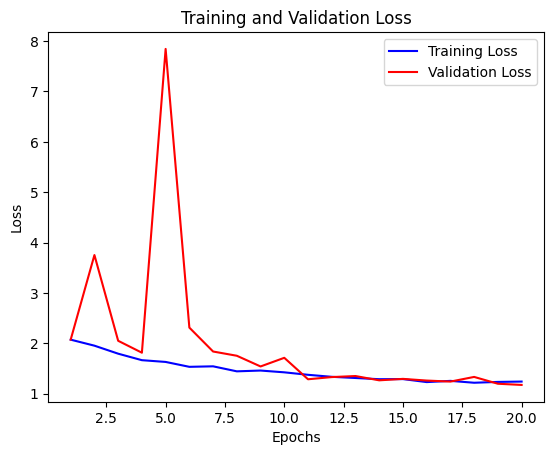

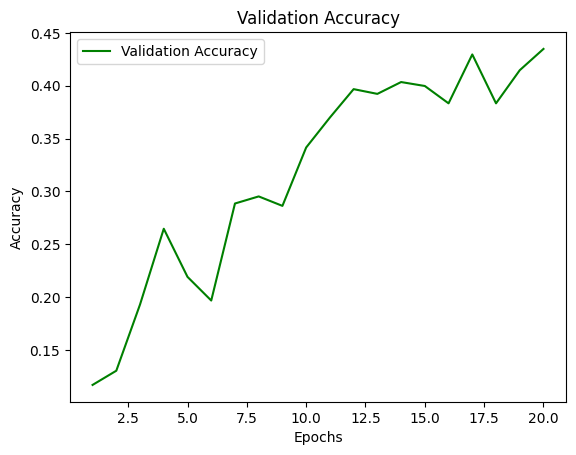

In [24]:
plotter.plot_training_val_b1(train_losses, val_losses, val_accuracies)